# Experiment Pipeline: LinkNet

In [1]:
import torch
import torch.optim as optim

from hubmap.experiments.load_data import make_expert_loader
from hubmap.experiments.load_data import make_annotated_loader
from hubmap.dataset import transforms as T
from hubmap.losses import BCEDiceLoss
from hubmap.losses import IoULoss
from hubmap.metrics import IoU
from hubmap.training import train
from hubmap.training import LRScheduler
from hubmap.training import EarlyStopping

from hubmap.metrics import model_size

c:\Users\gulBa\AppData\Local\pypoetry\Cache\virtualenvs\hubmap-nJ1voaj--py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First we load the data that we need for the experiment. This includes the training data, the validation (test) data that we will use for training.

For this, depending on the experiments we use different transformations on the data. The following transformations are a minimal example. Furhter transformations should be included for more sophisticated experiments.

In [2]:
# MINIMUM SIZE OF IMAGES FOR MODEL INPUT IS 64x64
IMG_DIM = 256

In [3]:
train_transformations = T.Compose(
    [
        T.ToTensor(),
        T.Resize((IMG_DIM, IMG_DIM)),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

test_transformations = T.Compose(
    [
        T.ToTensor(),
        T.Resize((IMG_DIM, IMG_DIM)),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

Depending on the experiment we may want to load all annotated images or just the ones that are annotated by experts.

Here we create a function to load all the images that are annotated (not only the ones by experts).
The created function can than be used to load the data loaders with a specific batch size.

In [4]:
# The train, test split ratio is set to 0.8 by default.
# Meaning 80% of the data is used for training and 20% for testing.
load_annotated_data = make_annotated_loader(train_transformations, test_transformations)

In the following, we determine the device we want to train on. 
If a GPU is available, we use it, otherwise we fall back to the CPU. 
We also set the random seed for reproducibility.

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device is: ", device)

device is:  cuda


Next, we need to load the model we want to train.

In [11]:
from hubmap.models import DPT
from hubmap.models import LinkNet
model = LinkNet(num_classes=4, pretrained=True).to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


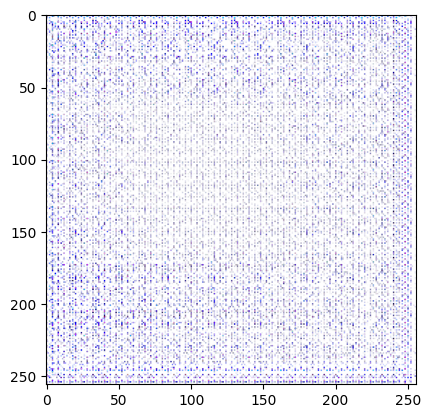

In [12]:
# # Quick test for random input.
import matplotlib.pyplot as plt
out = model(torch.zeros(size=(1, 3, IMG_DIM, IMG_DIM)).to(device))
out.shape
plt.imshow(out.squeeze().permute(1, 2, 0).detach().cpu())

Next we create the other modules needed for training, such as the loss measure, and the optimizer.

In [13]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# criterion = BCEDiceLoss()
criterion = IoULoss()
# WE ARE ONLY INTERESTED IN THE IoU OF THE BLOOD VESSEL CLASS FOR NOW.
benchmark = IoU(class_index=0)

Next, we initialize the trainer and start training. The trainer is responsible for running the training loop, saving checkpoints, and logging metrics 

In [18]:
BATCH_SIZE = 64

train_loader, test_loader, train_set, test_set = load_annotated_data(BATCH_SIZE)

In [19]:
# In addition we want to have a dynamic adjustment of the learning rate.
lr_scheduler = LRScheduler(optimizer, patience=20, min_lr=1e-6, factor=0.8)
# We will ignore the early stopping in this example.

In [20]:
result = train(
    num_epochs=25,
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    benchmark=benchmark,
    checkpoint_name="linknet_trials_iouloss",
    learning_rate_scheduler=lr_scheduler,
)

  0%|          | 0/15 [00:00<?, ?it/s]


ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [256, 256] and output size of torch.Size([256]). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

Now we can visualize the results.
(*this needs improvements + better and more visualizations for the final paper*)

In [16]:
import os
import matplotlib.pyplot as plt
from pathlib import Path
from hubmap.visualization import visualize_result

In [17]:
figures_path = Path().cwd() / "figures"
os.makedirs(figures_path, exist_ok=True)

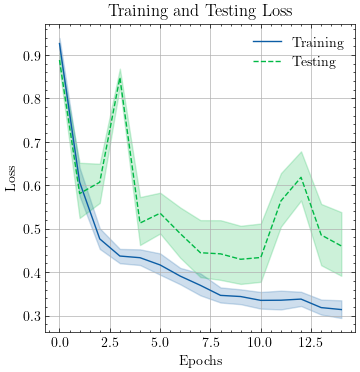

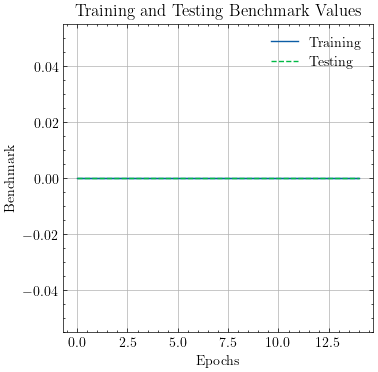

In [18]:
loss_fig, benchmark_fig = visualize_result(result)
loss_fig.savefig(Path(figures_path, "linknet_loss_iou.png"))
benchmark_fig.savefig(Path(figures_path, "linknet_benchmark_iou.png"))

#### Instance prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256])


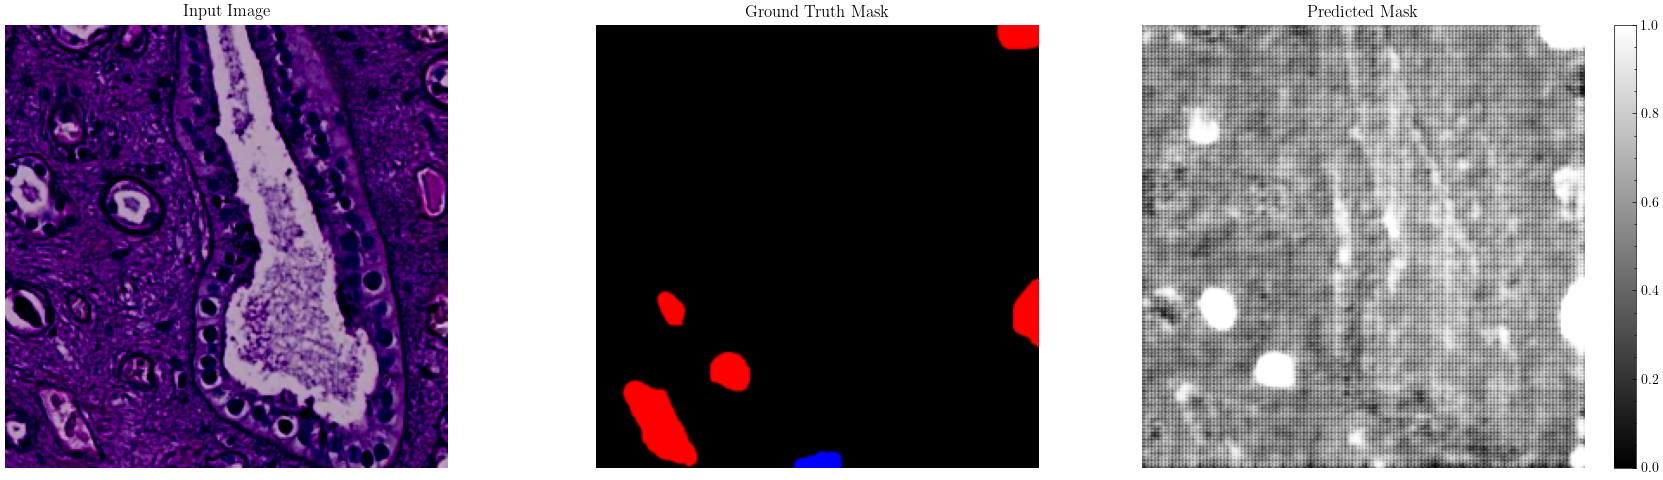

In [21]:
index = 20
image, mask = test_set[index]
image = image.to(device)
mask = mask.to(device)

model.eval()
with torch.no_grad():
    output = model(image.unsqueeze(0))
    predicted_mask = torch.softmax(output.data, dim=1).squeeze().cpu().permute(1, 2, 0)[:,:,0]
    #predicted_mask = torch.argmax(output.data, dim=1).squeeze().cpu()

# Normalize image values between 0 and 1
predicted_mask = (predicted_mask - predicted_mask.min()) / (predicted_mask.max() - predicted_mask.min())
print(predicted_mask.shape)

image = image.permute(1, 2, 0)
#mask returns blood vessel, glomerulus and unsure mask on seperate RGB channels. 
#This means e.g. blood vessel is always displayed red, glomerulus green, unsure blue
mask = mask.permute(1, 2, 0)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].imshow(image.cpu())
ax[0].set_title('Input Image')
ax[0].axis('off')
ground_truth = ax[1].imshow(mask.cpu(), cmap='gray')
ax[1].set_title('Ground Truth Mask')
ax[1].axis('off')
pred = ax[2].imshow(predicted_mask.numpy(), cmap='gray')
ax[2].imshow(predicted_mask, cmap='gray')
ax[2].set_title('Predicted Mask')
ax[2].axis('off')

# Adding a color bar to the third subplot
#colorbar = fig.colorbar(ground_truth, ax=ax[1])
colorbar = fig.colorbar(pred, ax=ax[2])
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PIL import Image

def plot_image_with_masks(df):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    unique_ids = df['id'].unique()
    if len(unique_ids) < 9:
        sampled_ids = np.random.choice(unique_ids, size=9, replace=True)
    else:
        sampled_ids = np.random.choice(unique_ids, size=9, replace=False)

    for i, image_id in enumerate(sampled_ids):
        image_path = f"{DATA_PATH}/train/{image_id}.tif"
        image = np.array(Image.open(image_path))

        # Plot the image
        axes[i].imshow(image)
        axes[i].axis('off')

        # Get the masks for the current image ID
        masks = df[df['id'] == image_id]

        # Plot the polygon masks
        for _, row in masks.iterrows():
            mask_type = row['type']
            coordinates = row['coordinates']
            color = get_mask_color(mask_type)
            for coord in coordinates:
                polygon = Polygon(coord, closed=True, edgecolor=color, linewidth=2, fill=False)
                axes[i].add_patch(polygon)

        # Set the title as the image ID
        axes[i].set_title(f"ID: {image_id}")

    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], color='blue', linewidth=2, label='Glomerulus'),
        plt.Line2D([0], [0], color='red', linewidth=2, label='Blood Vessel'),
        plt.Line2D([0], [0], color='green', linewidth=2, label='Unsure')
    ]
    axes[-1].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()

def get_mask_color(mask_type):
    if mask_type == 'glomerulus':
        return 'blue'
    elif mask_type == 'blood_vessel':
        return 'red'
    elif mask_type == 'unsure':
        return 'green'
    else:
        return 'black'  # Default color if mask type is unknown

# Call the function with your dataframe
plot_image_with_masks(poly_df)